# Introduction

The Brazilian immigration wave to the US hit its peak in the 1990s and early 2000s. During the 17 years between 1990 and 2007 over 275,000 Brazilians migrated to the United States. In total, around 7% of the entire US Brazilian population lives in New York City.

According to the United States Census Bureau, in a survey from 2012, there were 72,635 brazilians living in NYC. It is the main metropolitan area of brazilian population, followed by Boston (63,930) and Miami (43,930).

So, where exactly do Brazilians hang out in the city? Where can you find feijoada (a stew of beans with beef and pork) and other delicious Brazilian foods?

This project will attempt to answer the questions “Where should an investor open a Brazilian Restaurant in NYC?” and “Where should I go If I want great Brazilian food?”

# Data

In order to answer the above questions, data on New York City neighborhoods, boroughs to include boundaries, latitude, longitude, restaurants, and restaurant ratings and tips are required.

New York City data containing the neighborhoods and boroughs, latitudes, and longitudes will be obtained from the data source: https://cocl.us/new_york_dataset

All data related to locations and quality of Brazilian restaurants will be obtained via the FourSquare API utilized via the Request library in Python.

# Methods

• Data will be collected from https://cocl.us/new_york_dataset and cleaned and processed into a dataframe.

• FourSquare be used to locate all venues and then filtered by Brazilian restaurants. Ratings, tips, and likes by users will be counted and added to the dataframe.

• Data will be sorted based on rankings.

• Finally, the data be will be visually assessed using graphing from Python libraries.

In [ ]:
# Importing Libraries

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests # library to handle requests

#from bs4 import BeautifulSoup
import os

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import seaborn as sns

print('Libraries imported.')

In [2]:
# Defining Foursquare Credentials

CLIENT_ID = 'MKZSGN3QMDZ4UH1NGESBX0APBNFHGWR2BRDYQHB0IZGMNNPI' # your Foursquare ID
CLIENT_SECRET = 'W4XDRX40OYD05HDZ4QHRNKQE2NBKNT2J4S14IWI41NEKBHAO' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [3]:
# Defining functions for later use

def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [4]:
# Getting NYC data
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [5]:
# Evaluating data
ny_data.shape

(306, 4)

306 different Neighborhoods in New York City

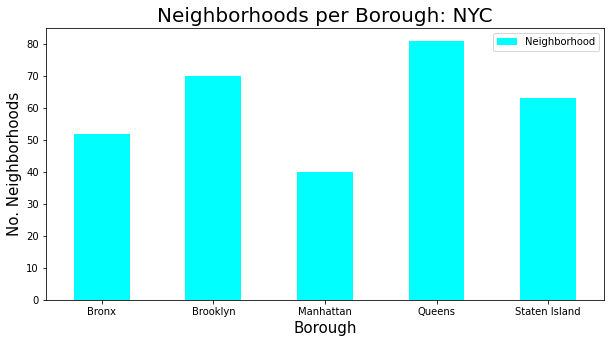

In [6]:
# Analysing the data

clr = "cyan"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

### Number of Brazilian restaurants in each neighborhood and borough

In [7]:
# queens has most neighborhoods
# prepare neighborhood list that contains brazilian restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
brazilian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    brazilian_restaurants=venues[venues['Category']=='Brazilian Restaurant']   
    print('(',count,'/',len(ny_data),')','Brazilian Restaurants in '+Neighborhood+', '+Borough+':'+str(len(brazilian_restaurants)))
    print(row)
    for resturant_detail in brazilian_restaurants.values.tolist():
        id, name , category=resturant_detail
        brazilian_rest_ny = brazilian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Brazilian Restaurants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Brazilian Restaurants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Brazilian Restaurants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Brazilian Restaurants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Brazilian Restaurants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Brazilian Restaurants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Brazilian Restaurants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Brazilian Restaurants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Brazilian Restaurants in N

( 67 / 306 ) Brazilian Restaurants in Carroll Gardens, Brooklyn:0
['Brooklyn', 'Carroll Gardens', 40.680540231076485, -73.99465372828006]
( 68 / 306 ) Brazilian Restaurants in Red Hook, Brooklyn:0
['Brooklyn', 'Red Hook', 40.676253230250886, -74.0127589747356]
( 69 / 306 ) Brazilian Restaurants in Gowanus, Brooklyn:0
['Brooklyn', 'Gowanus', 40.673931143187154, -73.99444087145339]
( 70 / 306 ) Brazilian Restaurants in Fort Greene, Brooklyn:0
['Brooklyn', 'Fort Greene', 40.68852726018977, -73.97290574369092]
( 71 / 306 ) Brazilian Restaurants in Park Slope, Brooklyn:0
['Brooklyn', 'Park Slope', 40.67232052268197, -73.97705030183924]
( 72 / 306 ) Brazilian Restaurants in Cypress Hills, Brooklyn:0
['Brooklyn', 'Cypress Hills', 40.68239101144211, -73.87661596457296]
( 73 / 306 ) Brazilian Restaurants in East New York, Brooklyn:0
['Brooklyn', 'East New York', 40.669925700847045, -73.88069863917366]
( 74 / 306 ) Brazilian Restaurants in Starrett City, Brooklyn:0
['Brooklyn', 'Starrett City', 

( 129 / 306 ) Brazilian Restaurants in Financial District, Manhattan:0
['Manhattan', 'Financial District', 40.70710710727048, -74.0106654452127]
( 130 / 306 ) Brazilian Restaurants in Astoria, Queens:1
['Queens', 'Astoria', 40.76850859335492, -73.91565374304234]
( 131 / 306 ) Brazilian Restaurants in Woodside, Queens:0
['Queens', 'Woodside', 40.74634908860222, -73.90184166838284]
( 132 / 306 ) Brazilian Restaurants in Jackson Heights, Queens:0
['Queens', 'Jackson Heights', 40.75198138007367, -73.88282109164365]
( 133 / 306 ) Brazilian Restaurants in Elmhurst, Queens:0
['Queens', 'Elmhurst', 40.744048505122024, -73.88165622288388]
( 134 / 306 ) Brazilian Restaurants in Howard Beach, Queens:0
['Queens', 'Howard Beach', 40.65422527738487, -73.8381376460028]
( 135 / 306 ) Brazilian Restaurants in Corona, Queens:0
['Queens', 'Corona', 40.74238175015667, -73.85682497345258]
( 136 / 306 ) Brazilian Restaurants in Forest Hills, Queens:0
['Queens', 'Forest Hills', 40.72526378216503, -73.8444750

( 194 / 306 ) Brazilian Restaurants in Brookville, Queens:0
['Queens', 'Brookville', 40.66000322733613, -73.75175310731153]
( 195 / 306 ) Brazilian Restaurants in Bellaire, Queens:0
['Queens', 'Bellaire', 40.73301404027834, -73.73889198912481]
( 196 / 306 ) Brazilian Restaurants in North Corona, Queens:0
['Queens', 'North Corona', 40.7540709990489, -73.85751790676447]
( 197 / 306 ) Brazilian Restaurants in Forest Hills Gardens, Queens:0
['Queens', 'Forest Hills Gardens', 40.7146110815117, -73.8410221123401]
( 198 / 306 ) Brazilian Restaurants in St. George, Staten Island:0
['Staten Island', 'St. George', 40.6449815710044, -74.07935312512797]
( 199 / 306 ) Brazilian Restaurants in New Brighton, Staten Island:0
['Staten Island', 'New Brighton', 40.64061455913511, -74.08701650516625]
( 200 / 306 ) Brazilian Restaurants in Stapleton, Staten Island:0
['Staten Island', 'Stapleton', 40.62692762538176, -74.07790192660066]
( 201 / 306 ) Brazilian Restaurants in Rosebank, Staten Island:0
['State

( 254 / 306 ) Brazilian Restaurants in Clifton, Staten Island:0
['Staten Island', 'Clifton', 40.61917845202843, -74.072642445484]
( 255 / 306 ) Brazilian Restaurants in Concord, Staten Island:0
['Staten Island', 'Concord', 40.6044731896879, -74.08402364740358]
( 256 / 306 ) Brazilian Restaurants in Emerson Hill, Staten Island:0
['Staten Island', 'Emerson Hill', 40.606794394801, -74.09776206972522]
( 257 / 306 ) Brazilian Restaurants in Randall Manor, Staten Island:0
['Staten Island', 'Randall Manor', 40.63563000681151, -74.09805062373887]
( 258 / 306 ) Brazilian Restaurants in Howland Hook, Staten Island:0
['Staten Island', 'Howland Hook', 40.63843283794795, -74.18622331749823]
( 259 / 306 ) Brazilian Restaurants in Elm Park, Staten Island:0
['Staten Island', 'Elm Park', 40.630146741193826, -74.1418167896889]
( 260 / 306 ) Brazilian Restaurants in Remsen Village, Brooklyn:0
['Brooklyn', 'Remsen Village', 40.652117451793494, -73.91665331978048]
( 261 / 306 ) Brazilian Restaurants in New

In [42]:
#brazilian_rest_ny.to_csv('brazilian_rest_ny_tocsv1.csv')
# Save the information so far to a .csv file due to limited calls on FourSquare
brazilian_rest_ny.to_csv('brazilian_rest_ny_tocsv1.csv')

In [13]:
brazilian_ny = pd.read_csv('brazilian_rest_ny_tocsv1.csv')
brazilian_rest_ny.tail()

,Borough,Neighborhood,ID,Name
0,Manhattan,West Village,3fd66200f964a52008e71ee3,Casa
1,Queens,Astoria,4bdf502a89ca76b062b75d5e,Favela Grill


In [14]:
brazilian_rest_ny.shape

(2, 4)

There are only two brazilian restaurants in NYC, even though the brazilian population reachs its tens of thousands in the City.

At least, that is the information retrieved. It is possible that there are many other restaurants that are not classified as "brazilian restaurant".

These are commom issues in data science. We will work with these two instances of data and try to get the most of them.

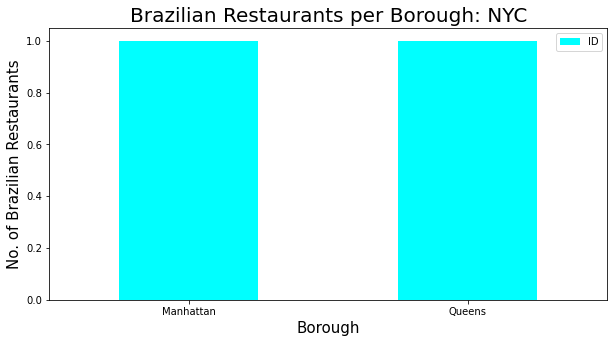

In [17]:
brazilian_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Brazilian Restaurants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of Brazilian Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

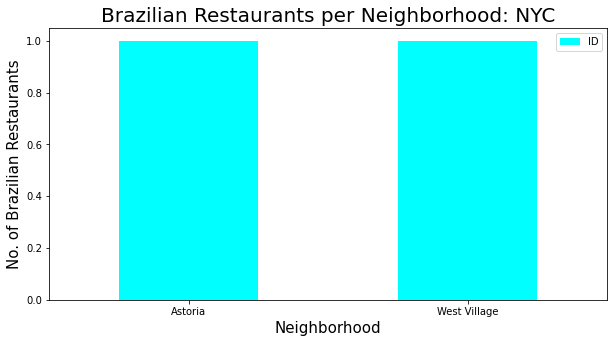

In [18]:
NOofNeigh = 2 # top number for graphing all the same past 2
brazilian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Brazilian Restaurants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No. of Brazilian Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

One of the restaurants is located at West Village, Manhattan, while the other is in Astoria, Queens.

While many Brazilians have dispersed throughout the city, Astoria seems to be the main home of Brazilians in NYC. It is expected that we would find a brazilian restaurant there.

West Village's option may be more related to touristic activities, considering it is on the Manhattan Borough.

In [19]:
brazilian_rest_ny[brazilian_rest_ny['Neighborhood']=='Astoria']

,Borough,Neighborhood,ID,Name
1,Queens,Astoria,4bdf502a89ca76b062b75d5e,Favela Grill


In [20]:
brazilian_rest_ny[brazilian_rest_ny['Neighborhood']=='West Village']

,Borough,Neighborhood,ID,Name
0,Manhattan,West Village,3fd66200f964a52008e71ee3,Casa


### Evaluating both restaurants

In [21]:
# Getting the ranking of each restaurant

column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
brazilian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in brazilian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(brazilian_rest_ny),')','processed')
    brazilian_rest_stats_ny = brazilian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
brazilian_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '5fb28db6726940047dc38242'}, 'response': {'venue': {'id': '3fd66200f964a52008e71ee3', 'name': 'Casa', 'contact': {'phone': '2123669410', 'formattedPhone': '(212) 366-9410'}, 'location': {'address': '72 Bedford St', 'crossStreet': 'Commerce', 'lat': 40.731493, 'lng': -74.004825, 'labeledLatLngs': [{'label': 'entrance', 'lat': 40.731463, 'lng': -74.004819}, {'label': 'display', 'lat': 40.731493, 'lng': -74.004825}], 'postalCode': '10014', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['72 Bedford St (Commerce)', 'New York, NY 10014', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/casa/3fd66200f964a52008e71ee3', 'categories': [{'id': '4bf58dd8d48988d16b941735', 'name': 'Brazilian Restaurant', 'pluralName': 'Brazilian Restaurants', 'shortName': 'Brazilian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/argentinian_', 'suffix': '.png'}, 'primary': True}, {'id': '4def73e84765a

{'meta': {'code': 200, 'requestId': '5fb28db64450ba020e99731b'}, 'response': {'venue': {'id': '4bdf502a89ca76b062b75d5e', 'name': 'Favela Grill', 'contact': {'phone': '7185458250', 'formattedPhone': '(718) 545-8250'}, 'location': {'address': '33-18 28th Ave', 'crossStreet': 'btwn 33rd & 34th St.', 'lat': 40.76734843380796, 'lng': -73.91789747356819, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76734843380796, 'lng': -73.91789747356819}], 'postalCode': '11103', 'cc': 'US', 'city': 'Astoria', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['33-18 28th Ave (btwn 33rd & 34th St.)', 'Astoria, NY 11103', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/favela-grill/4bdf502a89ca76b062b75d5e', 'categories': [{'id': '4bf58dd8d48988d16b941735', 'name': 'Brazilian Restaurant', 'pluralName': 'Brazilian Restaurants', 'shortName': 'Brazilian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/argentinian_', 'suffix': '.png'}, 'primary': True}], 'verifie

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Manhattan,West Village,3fd66200f964a52008e71ee3,Casa,194,8.7,66
1,Queens,Astoria,4bdf502a89ca76b062b75d5e,Favela Grill,86,8.4,57


In [43]:
brazilian_rest_stats_ny.to_csv('brazilian_rest_stats_ny_csv.csv') # As I move through this project I continue to save data to a .csv file

In [24]:
brazilian_rest_stats_ny.shape

(2, 7)

In [25]:
brazilian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       2 non-null      object 
 1   Neighborhood  2 non-null      object 
 2   ID            2 non-null      object 
 3   Name          2 non-null      object 
 4   Likes         2 non-null      object 
 5   Rating        2 non-null      float64
 6   Tips          2 non-null      object 
dtypes: float64(1), object(6)
memory usage: 240.0+ bytes


In [26]:
# Turning likes and tips into float

brazilian_rest_stats_ny['Likes'] = brazilian_rest_stats_ny['Likes'].astype('float64')
brazilian_rest_stats_ny['Tips'] = brazilian_rest_stats_ny['Tips'].astype('float64')
brazilian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       2 non-null      object 
 1   Neighborhood  2 non-null      object 
 2   ID            2 non-null      object 
 3   Name          2 non-null      object 
 4   Likes         2 non-null      float64
 5   Rating        2 non-null      float64
 6   Tips          2 non-null      float64
dtypes: float64(3), object(4)
memory usage: 240.0+ bytes


### Evaluating the results

In [27]:
brazilian_rest_stats_ny.describe()

,Likes,Rating,Tips
count,2.000000,2.000000,2.000000
mean,140.000000,8.550000,61.500000
std,76.367532,0.212132,6.363961
min,86.000000,8.400000,57.000000
25%,113.000000,8.475000,59.250000
50%,140.000000,8.550000,61.500000
75%,167.000000,8.625000,63.750000
max,194.000000,8.700000,66.000000


In [30]:
# Restaurant with maximum Likes
brazilian_rest_stats_ny.iloc[brazilian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                West Village
ID              3fd66200f964a52008e71ee3
Name                                Casa
Likes                                194
Rating                               8.7
Tips                                  66
Name: 0, dtype: object

In [32]:
# Restaurant with maximum Ratings
brazilian_rest_stats_ny.iloc[brazilian_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                West Village
ID              3fd66200f964a52008e71ee3
Name                                Casa
Likes                                194
Rating                               8.7
Tips                                  66
Name: 0, dtype: object

In [33]:
# Restaurant with maximum Tips
brazilian_rest_stats_ny.iloc[brazilian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                West Village
ID              3fd66200f964a52008e71ee3
Name                                Casa
Likes                                194
Rating                               8.7
Tips                                  66
Name: 0, dtype: object

### Avarege from one observation! Statistics with no data...

Even though it makes no sense to get too much statistics from these two observations, I'll leave it here so that the same piece of code can be used for evaluating a different set of data, with more observations...

In [35]:
# Getting the avarege rate of a neighborhood... with only one observation.
ny_neighborhood_stats=brazilian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
1,West Village,8.7
0,Astoria,8.4


In [36]:
# Getting the avarege rate of a borough... with only one observation.
ny_borough_stats=brazilian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
0,Manhattan,8.7
1,Queens,8.4


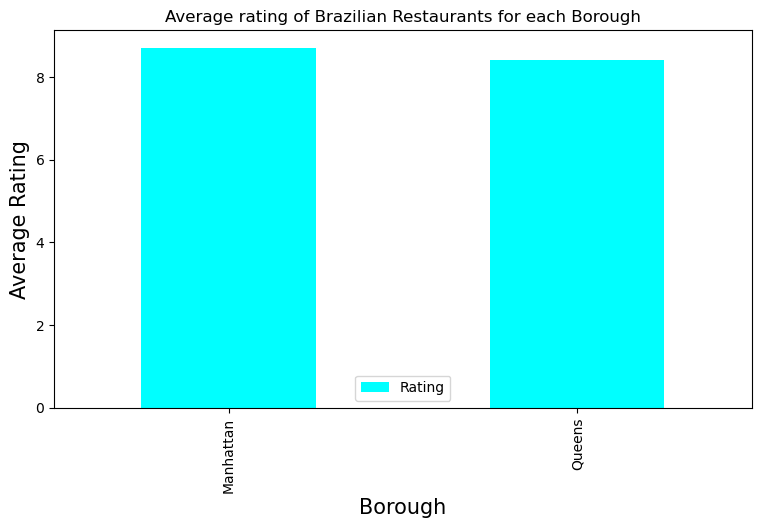

In [38]:
# Visualizing the avareges of one observation... fells kind of dumb...

plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Brazilian Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
brazilian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color=clr)
plt.legend()
plt.show()

In [39]:
# Joining the datasets to get longitute and latitude

ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Queens,Astoria,40.768509,-73.915654,8.4
1,Manhattan,West Village,40.734434,-74.006180,8.7


In [40]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [41]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add ratings to map
ny_map.add_child(rating)

# Results and Conclusions

Both West Village (Manhattan) and Astoria (Queens) have high rates for their brazilian restaurants.

During the course of this project, there was this main issue related to the amount of data. Even though there is an elevated brazilian population in NYC and there probably are other brazilian restaurant options, these alternatives are not registered in FourSquare, or they are classified as something other than "brazilian restaurant".

Even with that issue, it was possible to create a project that used most of the tools and methods that were studied during the course.

The West Village restaurant seems to be the best brazilian restaurant option according to its statistics in ForSquare. However, it is closely followed by the Astoria restaurant. Other factors, such as accessibility might be added to the evaluation in order to choose between them. Anyway, the first choice would be the West Village restaurant, but it would be interesting to try both of them.

If it were to open a new Brazilian restaurant, Manhattan or Queens would be interesting choices of borough. Manhattan seems to be able to have a greater public, considering its higher number of "Likes".